# German credit fraud

http://weka.8497.n7.nabble.com/file/n23121/credit_fruad.arff

Professor Dr. Hans Hofmann

Institut fur Statistik und Okonometrie Universitat Hamburg  
FB Wirtschaftswissenschaften  
Von-Melle-Park 5    
2000 Hamburg 13

# Exploratory data analysis
1. [Data import and summary](#Data-import-and-summary)
- [Data preparation](#Data-preparation)
- [Correlation analysis](#Correlation-analysis)
- [Feature creation and selection](#Feature-creation-and-selection)

1. Remove the depiction against the output (Y) in `plot_categorical`
- Try visualizing all variables at once (alternatively, group them by ordinal/cardinal/continuous)
- Perform PCA/CA/t-SNE etc

---

## Data import and summary

In [2]:
%%html
<link rel="stylesheet" href="custom.css"/>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from utils import plot_categorical

In [4]:
df = pd.read_csv('data/german-credit.csv')
df.head()

over_draft  credit_usage                    credit_history  \
0           '<0'             6  'critical/other existing credit'   
1     '0<=X<200'            48                   'existing paid'   
2  'no checking'            12  'critical/other existing credit'   
3           '<0'            42                   'existing paid'   
4           '<0'            24              'delayed previously'   

               purpose  current_balance Average_Credit_Balance employment  \
0             radio/tv             1169     'no known savings'      '>=7'   
1             radio/tv             5951                 '<100'   '1<=X<4'   
2            education             2096                 '<100'   '4<=X<7'   
3  furniture/equipment             7882                 '<100'   '4<=X<7'   
4            'new car'             4870                 '<100'   '1<=X<4'   

   location       personal_status other_parties  ...   property_magnitude  \
0         4         'male single'          none  ...        'real estate'   
1         2  'female div/dep/mar'          none  ...        'real estate'   
2         2         'male single'          none  ...        'real estate'   
3         2         'male single'     guarantor  ...     'life insurance'   
4         3         'male single'          none  ...  'no known property'   

  cc_age  other_payment_plans     housing existing_credits  \
0     67                 none         own                2   
1     22                 none         own                1   
2     49                 none         own                1   
3     45                 none  'for free'                1   
4     53                 none  'for free'                2   

                    job num_dependents  own_telephone foreign_worker class  
0               skilled              1            yes            yes  good  
1               skilled              1           none            yes   bad  
2  'unskilled resident'              2           none            yes  good  
3               skilled              2           none            yes  good  
4               skilled              2           none            yes   bad  

[5 rows x 21 columns]

In [5]:
df.shape

(1000, 21)

In [6]:
df.describe(include=np.number).T

count      mean          std    min     25%     50%  \
credit_usage      1000.0    20.903    12.058814    4.0    12.0    18.0   
current_balance   1000.0  3271.258  2822.736876  250.0  1365.5  2319.5   
location          1000.0     2.973     1.118715    1.0     2.0     3.0   
residence_since   1000.0     2.845     1.103718    1.0     2.0     3.0   
cc_age            1000.0    35.546    11.375469   19.0    27.0    33.0   
existing_credits  1000.0     1.407     0.577654    1.0     1.0     1.0   
num_dependents    1000.0     1.155     0.362086    1.0     1.0     1.0   

                      75%      max  
credit_usage        24.00     72.0  
current_balance   3972.25  18424.0  
location             4.00      4.0  
residence_since      4.00      4.0  
cc_age              42.00     75.0  
existing_credits     2.00      4.0  
num_dependents       1.00      2.0

In [7]:
df.describe(include='O').T

count unique              top freq
over_draft              1000      4    'no checking'  394
credit_history          1000      5  'existing paid'  530
purpose                 1000     10         radio/tv  280
Average_Credit_Balance  1000      5           '<100'  603
employment              1000      5         '1<=X<4'  339
personal_status         1000      4    'male single'  548
other_parties           1000      3             none  907
property_magnitude      1000      4              car  332
other_payment_plans     1000      3             none  814
housing                 1000      3              own  713
job                     1000      4          skilled  630
own_telephone           1000      2             none  596
foreign_worker          1000      2              yes  963
class                   1000      2             good  700

There doesn't seem to be any obviously missing data.

In [8]:
df.isna().sum()

over_draft                0
credit_usage              0
credit_history            0
purpose                   0
current_balance           0
Average_Credit_Balance    0
employment                0
location                  0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
cc_age                    0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

### **class**
Output (categorical, binary)

In [9]:
df['class'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: class, dtype: float64

As we see, the output contains no missing values and is slightly imbalanced.

Let us now split the dataset into training and test subsets so we carry all the below analysis on the training part and leave the test one for prediction.

In [10]:
# import gc
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['class'])
# train.to_csv('data/train.csv', index=False)
# test.to_csv('data/test.csv', index=False)

# # Now free up the memory (is not guaranteed to work)
# del df, train, test
# gc.collect()

In [11]:
df = pd.read_csv('data/train.csv')

In [12]:
output = df['class'].map({'good': 0, 'bad': 1})
df.drop('class', axis=1, inplace=True)

---

## Preprocessing

We will start-off with the variables requiring special transformations and carry on with the rest after that.

In [13]:
import sklearn.preprocessing as pp
from sklearn.impute import MissingIndicator
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

### **over_draft**
Status of existing [checking account](https://en.wikipedia.org/wiki/Transaction_account) (categorical, mixed).

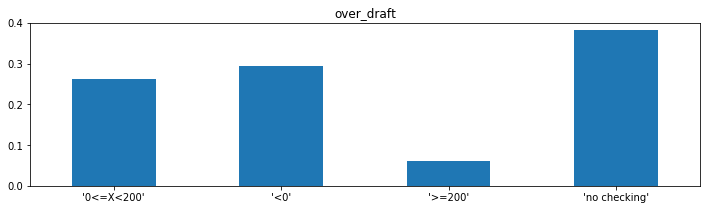

In [14]:
plot_categorical(df['over_draft'])

`'no checking'` does not fit the ordinal nature of the feature and should be extracted.

In [15]:
(df['over_draft'] == "'no checking'").value_counts(normalize=True)

False    0.618571
True     0.381429
Name: over_draft, dtype: float64

In [16]:
over_draft = pp.OrdinalEncoder([["'no checking'", "'<0'", "'0<=X<200'", "'>=200'"]])

### **credit_usage**
Duration in months (categorical, cardinal), alternatively - (numeric, integer).

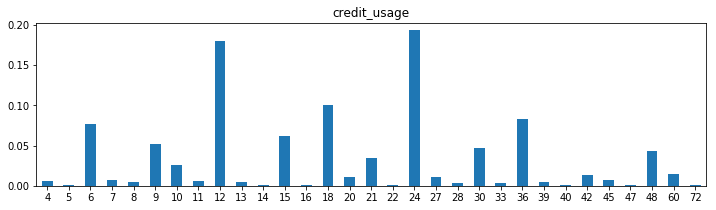

In [17]:
plot_categorical(df['credit_usage'])

If one decides to treat the feature as categorical, one can say that it demonstrates high cardinality and the levels are better be fused (collapsed) in order to reduce the effect. E.g. low-frequency levels can be merged into those that rise above, say, the 5% threshold.

If, otherwise, one decides to treat the feature as integer, nothing really needs to be done apart from simple scaling.

Being aware of the [negative effects of fusion (binning)](http://biostat.mc.vanderbilt.edu/wiki/Main/CatContinuous), we'll go the long way here to indicate that any cut points an algorithm could come up with other than those at the highly represented levels would be considered as overfitting.

In [18]:
class ThresholdBinner(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X):
        counts = X.iloc[:,0].value_counts(normalize=True).sort_index()
        self.max_value = counts.index.max()
        self.above_threshold = counts[counts >= self.threshold].index.values
        return self

    def transform(self, X):
        def mapper(x):
            for i in self.above_threshold:
                if x <= i:
                    return i
            return self.max_value
        return X.iloc[:,0].apply(mapper).values.reshape(-1, 1)

In [19]:
credit_usage = ThresholdBinner(0.05)

Let's check out what we've achieved with the above.

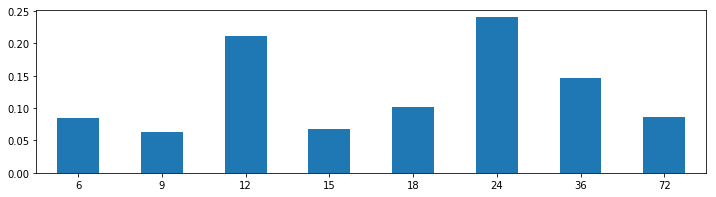

In [20]:
plot_categorical(pd.Series(credit_usage.fit_transform(df[['credit_usage']]).reshape(-1)))

### **credit_history**
Credit history (categorical, nominal).

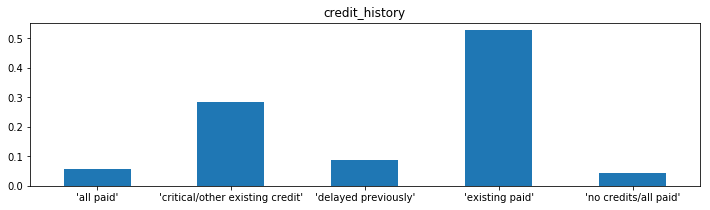

In [21]:
plot_categorical(df['credit_history'])

As we can see the underlying meaning of some of the levels is the same so we'll proceed with collapsing the levels accordingly to reduce dimensionality by applying domain knowledge.

In [22]:
class NominalMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapper):
        self.mapper = mapper

    def fit(self, X):
        return self

    def transform(self, X):
        return X.iloc[:,0].apply(self.mapper).values.reshape(-1, 1)

In [23]:
def mapper(x):
    if x in ["'existing paid'", "'no credits/all paid'", "'all paid'"]:
        return 'paid'
    elif x == "'critical/other existing credit'":
        return 'other_exist'
    elif x == "'delayed previously'":
        return 'delayed'
    else:
        return x

credit_history_map = NominalMapper(mapper)

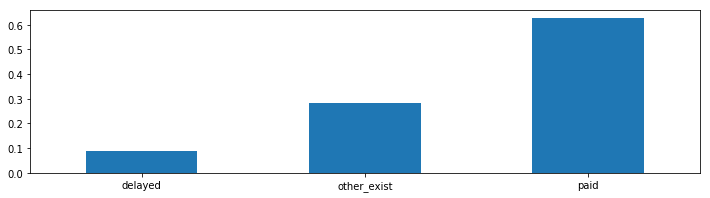

In [24]:
plot_categorical(pd.Series(credit_history_map.fit_transform(df[['credit_history']]).reshape(-1)))

In [25]:
credit_history = make_pipeline(credit_history_map, pp.OneHotEncoder())

### **purpose**
Loan purpose (categorical, nominal).

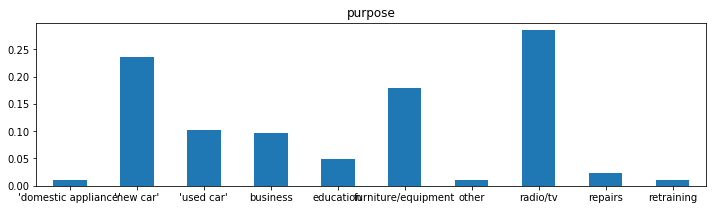

In [26]:
plot_categorical(df['purpose'])

In [27]:
def mapper(x):
    if x == 'furniture/equipment':
        return 'furniture'
    elif x == 'retraining':
        return 'education'
    elif x in ['repairs', "'domestic appliance'"]:
        return 'other'
    elif x == "'new car'":
        return 'new_car'
    elif x == "'used car'":
        return 'used_car'
    else:
        return x

purpose_map = NominalMapper(mapper)

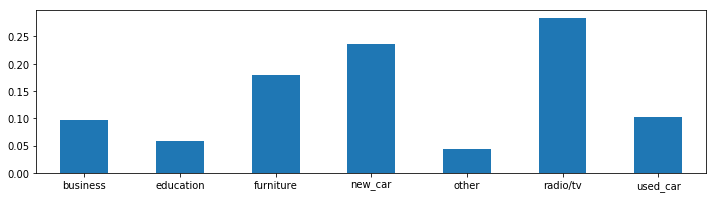

In [28]:
plot_categorical(pd.Series(purpose_map.fit_transform(df[['purpose']]).reshape(-1)))

In [29]:
purpose = make_pipeline(purpose_map, pp.OneHotEncoder())

### **Average_Credit_Balance**
Savings account/bonds (categorical, ordinal).

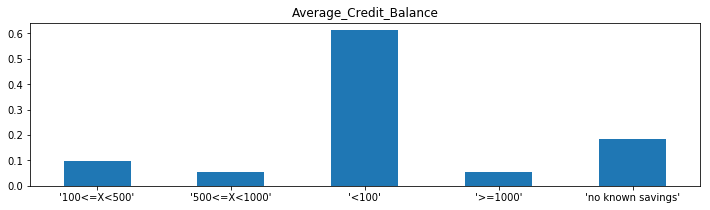

In [30]:
plot_categorical(df['Average_Credit_Balance'])

In [31]:
acb = pp.OrdinalEncoder([["'no known savings'", "'<100'", "'100<=X<500'", "'500<=X<1000'", "'>=1000'"]])

### **employment**
Present employment since, years (categorical, ordinal).

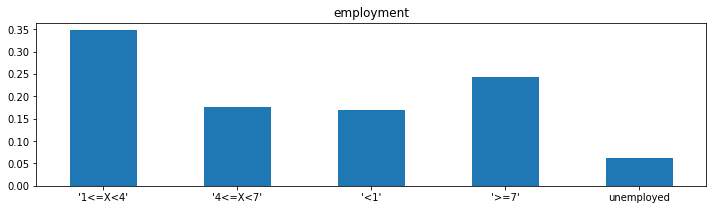

In [32]:
plot_categorical(df['employment'])

In [33]:
employment = pp.OrdinalEncoder([['unemployed', "'<1'", "'1<=X<4'", "'4<=X<7'", "'>=7'"]])

### **personal_status**
Personal status and sex (categorical, compound).

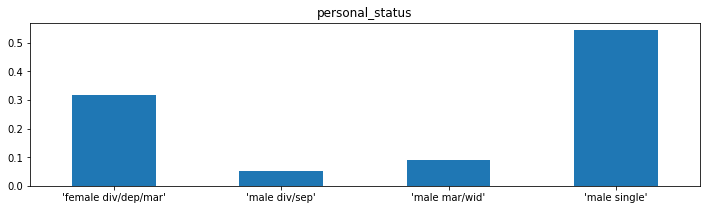

In [34]:
plot_categorical(df['personal_status'])

The feature seems like a mixture of `sex` and `marital status` but it really isn't since only one categorical level is attributed to females. Nevertheless, we will split this column into two anyway for illustrative purposes.

In [35]:
def mapper_sex(x):
    if x == "'female div/dep/mar'":
        return 'female'
    else:
        return 'male'
    
status_sex = make_pipeline(NominalMapper(mapper_sex), pp.OneHotEncoder())

In [36]:
def mapper_status(x):
    if x == "'male single'":
        return 'single'
    elif x == "'male div/sep'":
        return 'div/sep'
    elif x == "'male mar/wid'":
        return 'mar/wid'
    else:
        return x

status_married = make_pipeline(NominalMapper(mapper_status), pp.OneHotEncoder())

### **job**
Employment status (categorical, nominal).

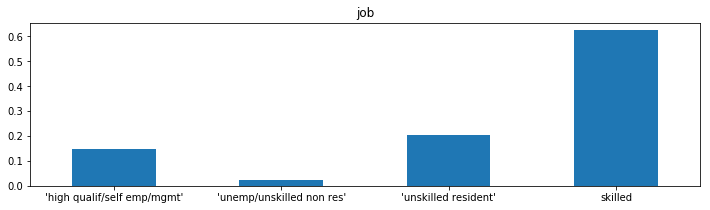

In [37]:
plot_categorical(df['job'])

In [38]:
def mapper(x):
    if x in ["'unskilled resident'", "'unemp/unskilled non res'"]:
        return 'unskilled'
    else:
        return x

job = make_pipeline(NominalMapper(mapper), pp.OneHotEncoder())

### **current_balance, cc_age**
Continuous numeric variables that do not require any special treatment (apart from the obvious scaling down below).  
We report `cc_age` as pseudo continuous here despite what we did to `credit_usage` earlier on.

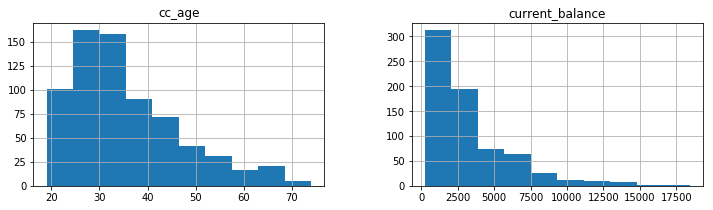

In [39]:
df[['current_balance', 'cc_age']].hist(figsize=(12, 3));

### **location, residence_since, existing_credits, num_dependents**
Relatively well-behaved categorical **ordinal** variables that do not require any immediate treatment.

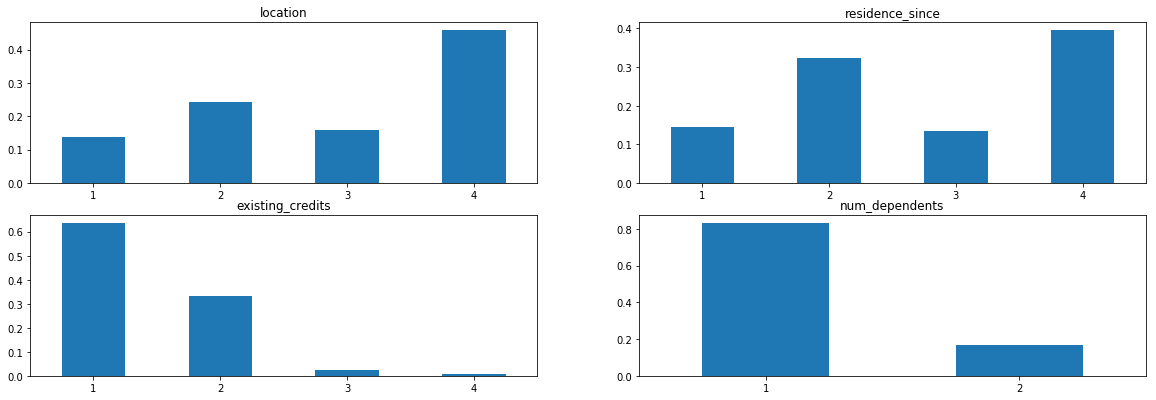

In [40]:
cols = ['location','residence_since', 'existing_credits', 'num_dependents']
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 6.5))
for col, ax in zip(cols, axes.flatten()):
    plot_categorical(df[col], ax)

### **other_parties, property_magnitude, other_payment_plans, housing, own_telephone, foreign_worker**
Relatively well-behaved categorical **nominal** variables that do not require any immediate treatment.

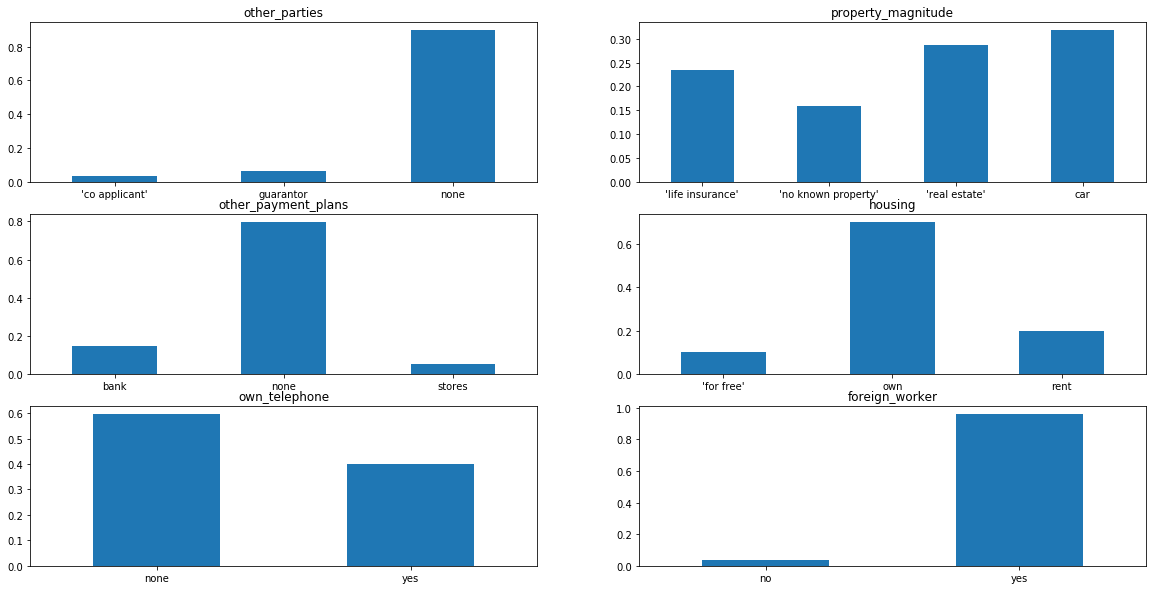

In [41]:
cols = ['other_parties', 'property_magnitude',
        'other_payment_plans', 'housing',
        'own_telephone', 'foreign_worker']
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
for col, ax in zip(cols, axes.flatten()):
    plot_categorical(df[col], ax)

---

## Pipeline

In [42]:
ct = make_column_transformer((over_draft, ['over_draft']),
                             (credit_usage, ['credit_usage']),
                             (credit_history, ['credit_history']),
                             (purpose, ['purpose']),
                             (acb, ['Average_Credit_Balance']),
                             (employment, ['employment']),
                             (status_sex, ['personal_status']),
                             (status_married, ['personal_status']),
                             (job, ['job']),
                             (pp.OneHotEncoder(), ['other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans',
                                                   'housing',
                                                   'own_telephone',
                                                   'foreign_worker']),
                             remainder='passthrough')

In [43]:
pipeline = make_pipeline(ct, pp.StandardScaler())
prep = pipeline.fit_transform(df)

In [44]:
df_prep = pd.DataFrame(prep, index=output)
df_prep.head()

0         1         2         3         4         5         6   \
class                                                                         
0      1.055466 -0.327602 -0.311735 -0.628031  0.768706  3.048626 -0.249430   
1     -1.064552  2.792417 -0.311735 -0.628031  0.768706  3.048626 -0.249430   
0     -1.064552 -1.020940 -0.311735 -0.628031  0.768706 -0.328017 -0.249430   
0      1.055466  2.792417  3.207853 -0.628031 -1.300887 -0.328017  4.009136   
1     -0.004543  0.019067 -0.311735 -0.628031  0.768706 -0.328017 -0.249430   

             7         8         9   ...        36        37       38  \
class                                ...                                
0     -0.466252 -0.555348 -0.215262  ... -1.221107  1.221107 -0.19245   
1     -0.466252 -0.555348 -0.215262  ... -1.221107  1.221107 -0.19245   
0     -0.466252 -0.555348 -0.215262  ...  0.818929 -0.818929 -0.19245   
0     -0.466252 -0.555348 -0.215262  ... -1.221107  1.221107 -0.19245   
1     -0.466252 -0.555348 -0.215262  ...  0.818929 -0.818929 -0.19245   

            39        40        41        42        43        44       45  
class                                                                      
0      0.19245 -0.476252  0.948917 -0.697911 -0.037214 -0.702693 -0.44798  
1      0.19245  0.558181  0.053712 -0.697911 -0.212632 -0.702693 -0.44798  
0      0.19245 -0.983314  0.053712 -1.591034 -0.563469 -0.702693 -0.44798  
0      0.19245  3.022578 -0.841493  0.195211 -0.300341 -0.702693 -0.44798  
1      0.19245 -0.477321  0.948917  0.195211 -0.300341 -0.702693 -0.44798  

[5 rows x 46 columns]

---

## Analysis

### Correlation

In [45]:
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix

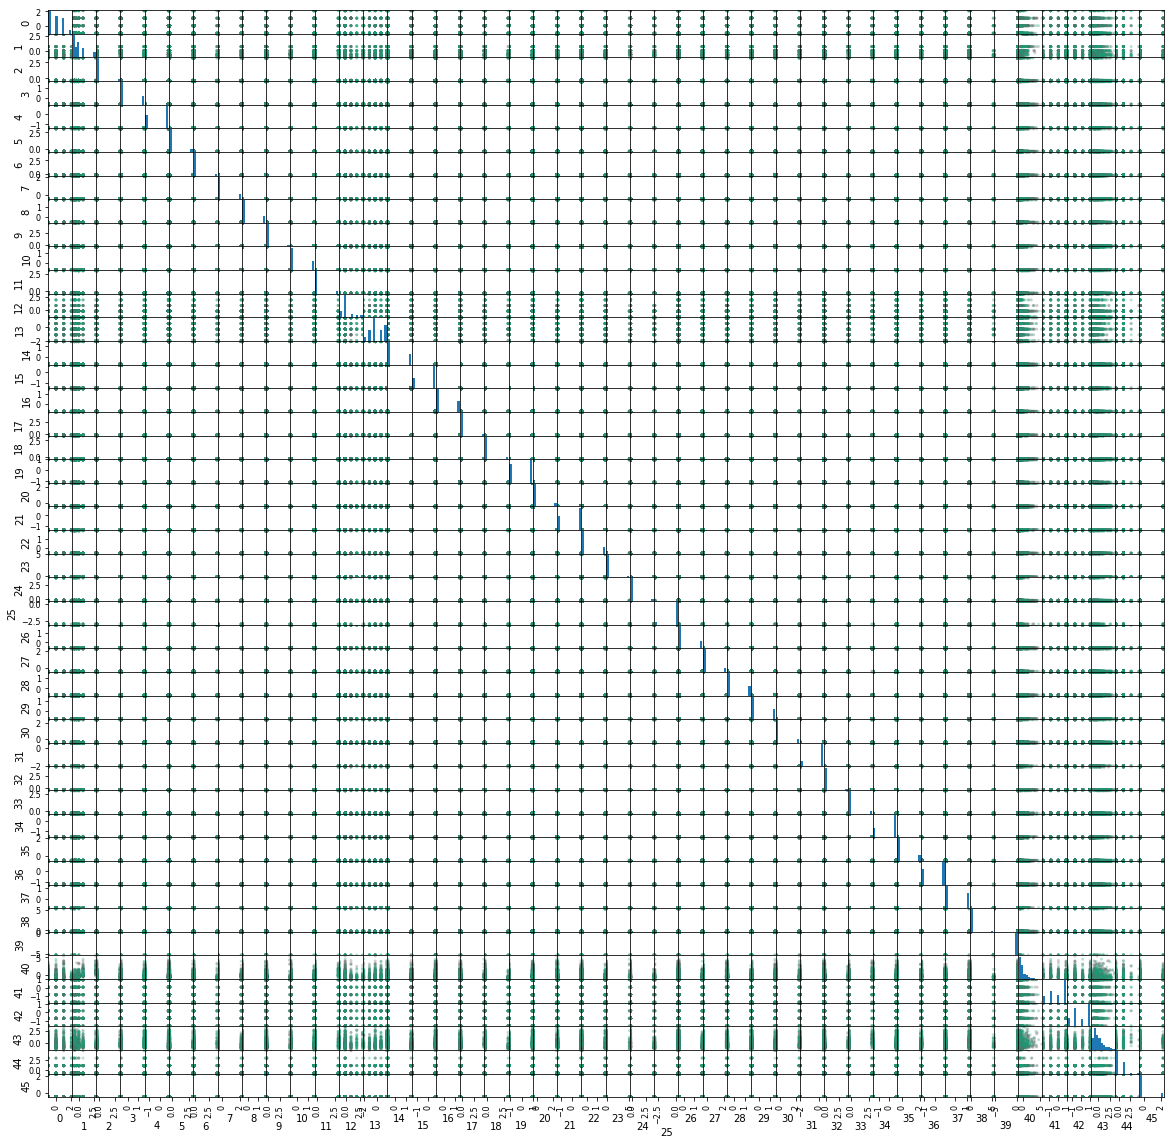

In [46]:
scatter_matrix(df_prep, figsize=(20, 20), c=df_prep.index, cmap='Dark2', alpha=0.3);

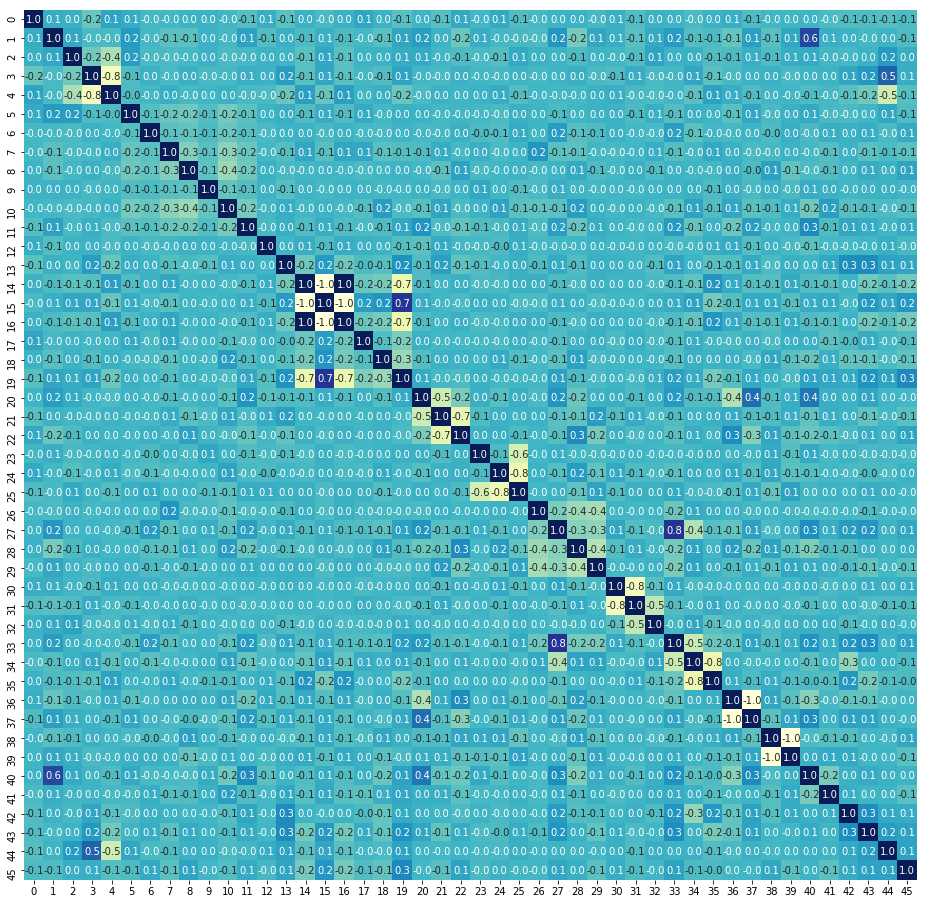

In [47]:
plt.figure(figsize=(16, 16))
sb.heatmap(df_prep.corr(), vmin=-1, vmax=1, annot=True, cbar=False, fmt='.1f', cmap='YlGnBu');

### PCA

In [48]:
from sklearn.decomposition import PCA

# Exclude the continuous columns 40 and 43
idx = list(range(40)) + [41, 42, 44, 45]
data = pd.DataFrame(prep)#, index=output)

pca = PCA()
X_pca = pca.fit_transform(data)

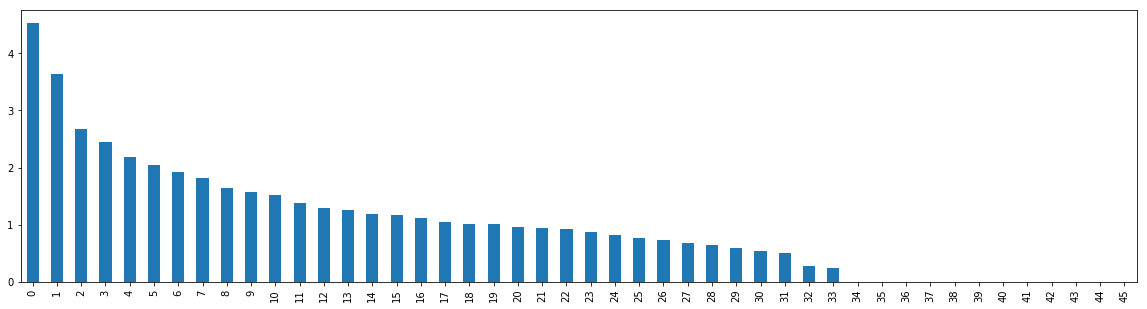

In [49]:
plt.figure(figsize=(20, 5))
pd.Series(pca.explained_variance_).plot(kind='bar');

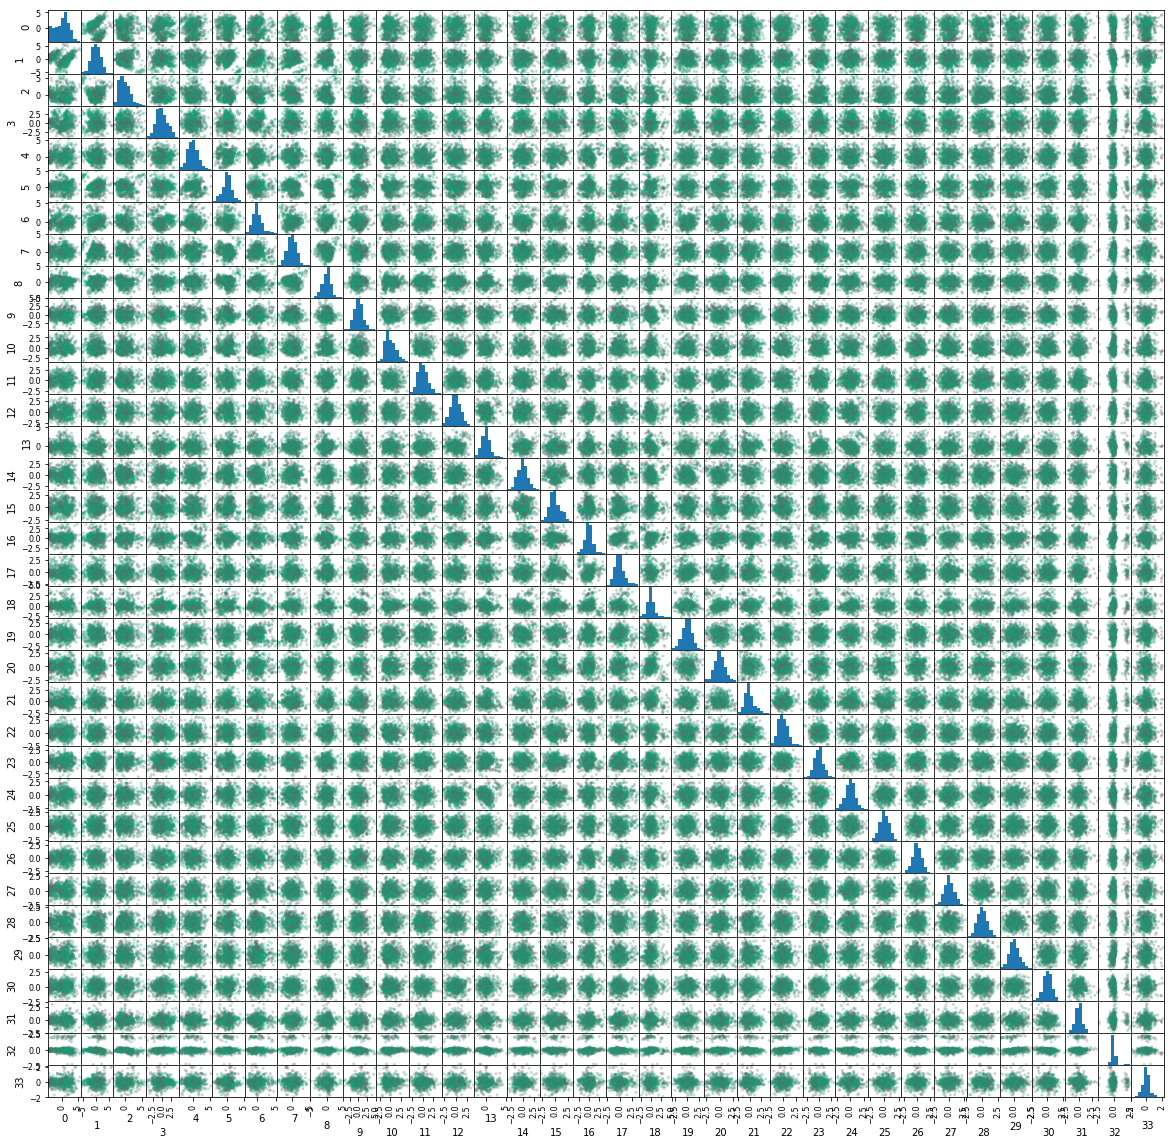

In [50]:
df_pca = pd.DataFrame(X_pca).iloc[:,0:34]

scatter_matrix(df_pca, figsize=(20, 20), c=output, cmap='Dark2', alpha=0.3);

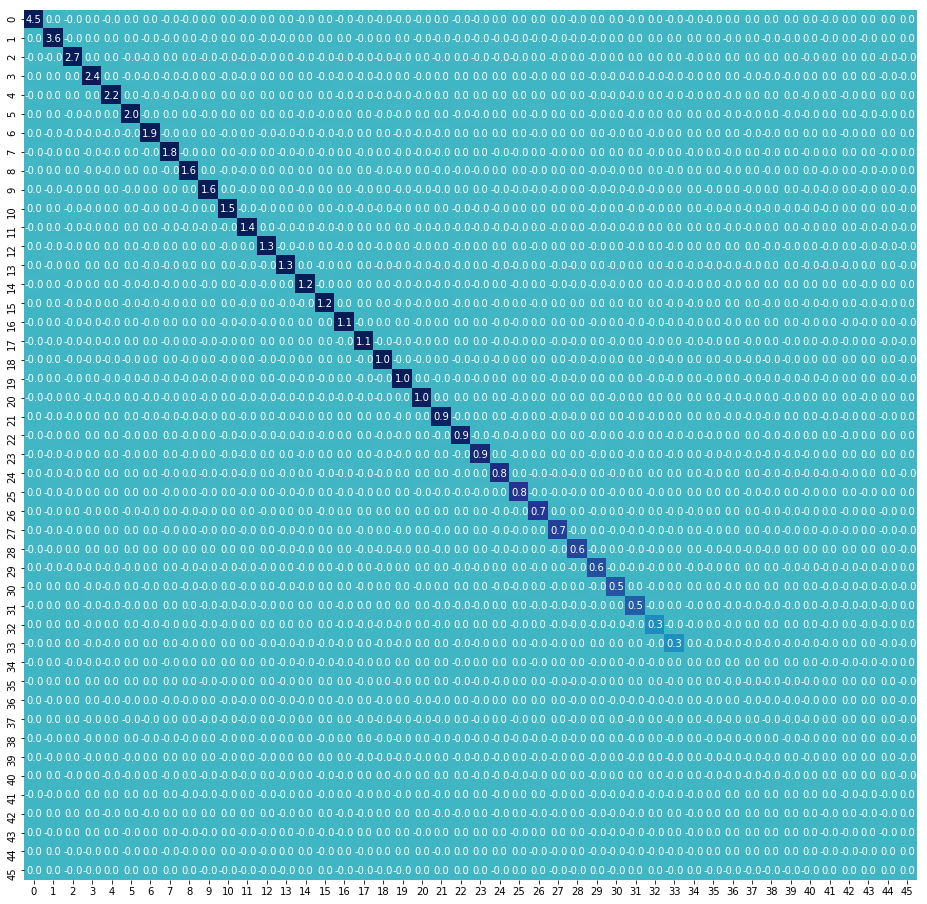

In [51]:
plt.figure(figsize=(16, 16))
sb.heatmap(pd.DataFrame(X_pca).cov(), vmin=-1, vmax=1, annot=True, cbar=False, fmt='.1f', cmap='YlGnBu');

### Linear discriminant analysis

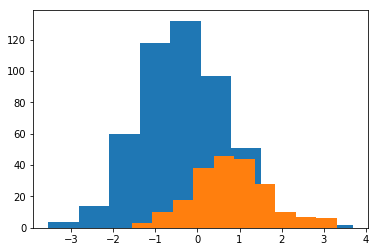

In [186]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_pca[:,0:34], output)

plt.hist(X_lda[output == 0])
plt.hist(X_lda[output == 1]);

### Multiple correspondence analysis (SVD of the $\chi^2$ of the crosstab matrix)

In [52]:
from prince import MCA

pipeline =  Pipeline([('transform', ct)])
prep_mca = pipeline.fit_transform(df)

# Exclude the continuous columns 40 and 43
idx = list(range(40)) + [42, 44, 45]
data = pd.DataFrame(prep_mca[:,idx], index=output)

mca = MCA(n_components=43)
X_mca = mca.fit_transform(data)

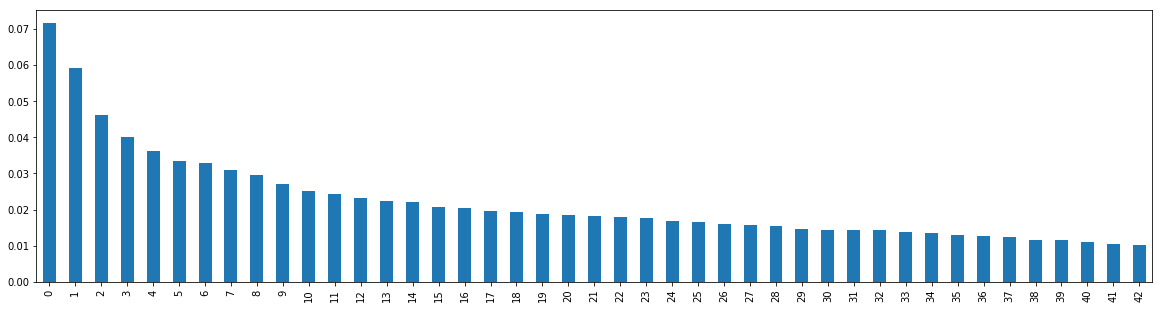

In [53]:
plt.figure(figsize=(20, 5))
pd.Series(mca.explained_inertia_).plot(kind='bar');

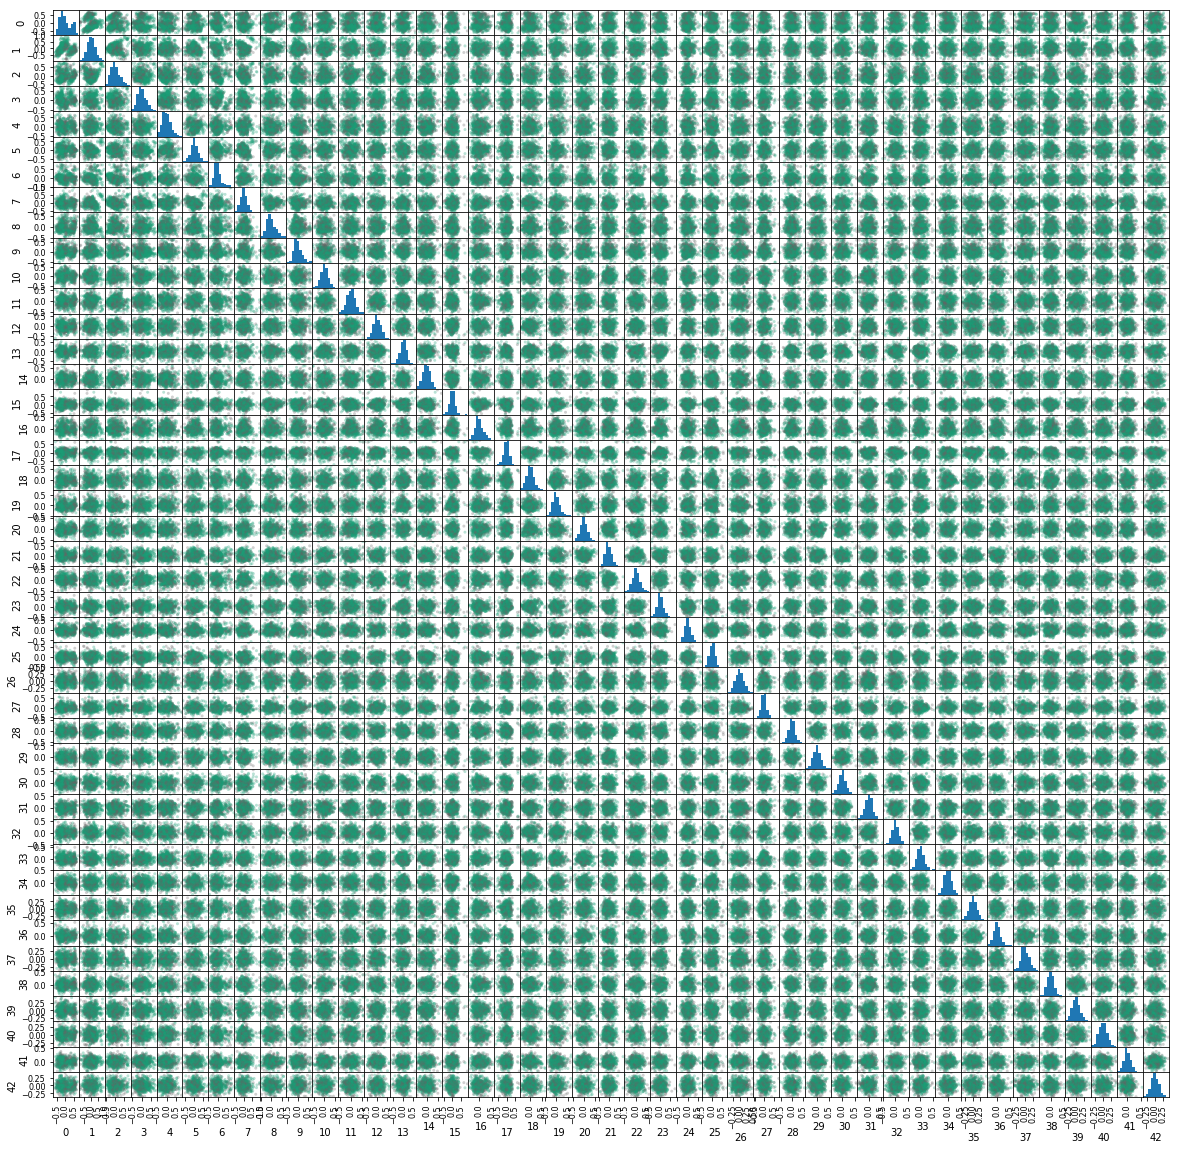

In [54]:
scatter_matrix(X_mca, figsize=(20, 20), c=output, cmap='Dark2', alpha=0.3);

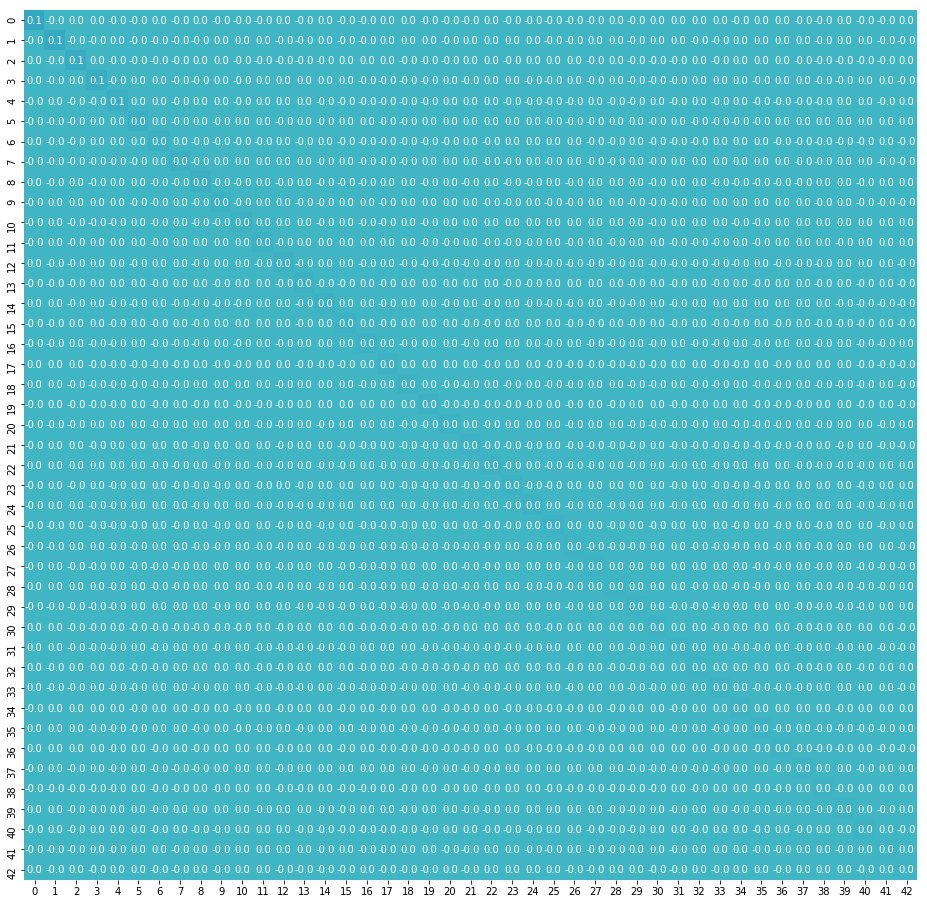

In [55]:
plt.figure(figsize=(16, 16))
sb.heatmap(X_mca.cov(), vmin=-1, vmax=1, annot=True, cbar=False, fmt='.1f', cmap='YlGnBu');

### Factor analysis of mixed data

In [56]:
from prince import FAMD

data = df.copy().set_index(output)

famd = FAMD(n_components=45)
X_famd = famd.fit_transform(data)

In [57]:
plt.figure(figsize=(20, 5))
pd.Series(famd.).plot(kind='bar');

SyntaxError: invalid syntax (<ipython-input-57-1bb3dc0cc658>, line 2)

In [ ]:
scatter_matrix(X_famd, figsize=(20, 20), c=output, cmap='Dark2', alpha=0.3);

In [ ]:
plt.figure(figsize=(16, 16))
sb.heatmap(X_famd.cov(), vmin=-1, vmax=1, annot=True, cbar=False, fmt='.1f', cmap='YlGnBu');

### Factor analysis

In [ ]:
from sklearn.decomposition import FactorAnalysis

data = pd.DataFrame(prep, index=output)

fa = FactorAnalysis()
X_fa = fa.fit_transform(data)

In [ ]:
plt.figure(figsize=(16, 16))
sb.heatmap(pd.DataFrame(X_fa).corr(), vmin=-1, vmax=1, annot=True, cbar=False, fmt='.1f', cmap='YlGnBu');

In [ ]:
plt.figure(figsize=(20, 5))
pd.Series(fa.noise_variance_).plot(kind='bar');

### Manifold projections

In [63]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from sklearn import manifold

def manifold_projections(X, color):
    n_neighbors = 10
    n_components = 2

    fig = plt.figure(figsize=(15, 8))

    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('Isomap')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('MDS')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('SpectralEmbedding')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    tsne = manifold.TSNE(n_components=n_components, init='pca')
    Y = tsne.fit_transform(X)
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('t-SNE')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

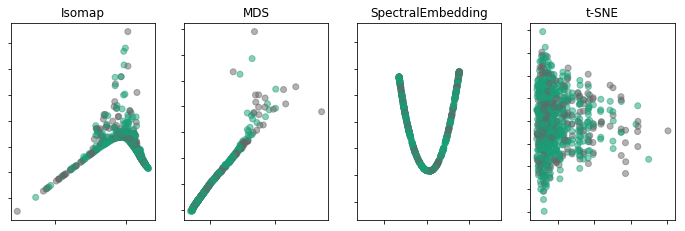

In [64]:
manifold_projections(prep, output)

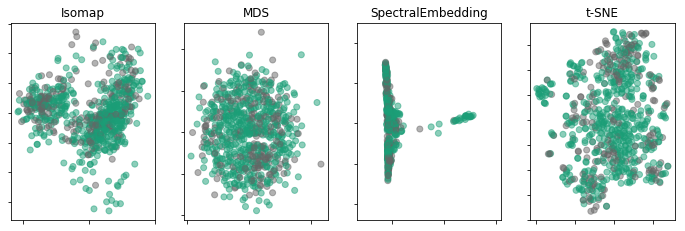

In [65]:
manifold_projections(X_mca, X_mca.index)

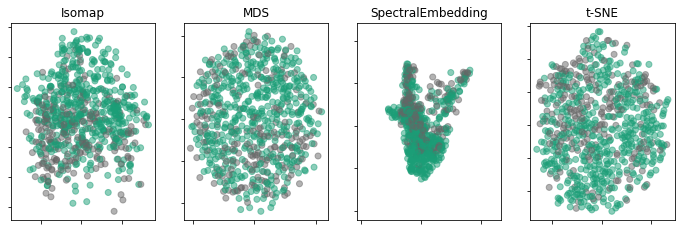

In [66]:
manifold_projections(X_famd, X_famd.index)

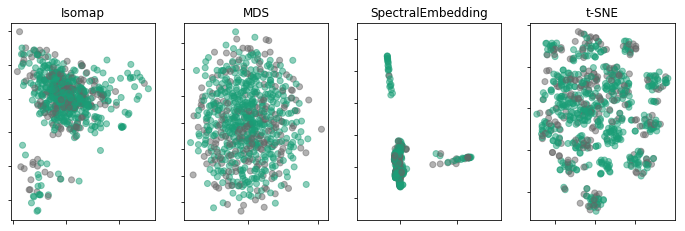

In [68]:
manifold_projections(pd.DataFrame(X_fa), output)

---

In [ ]:
df_prep.to_csv('data/german-credit-prep.csv', index=False)